In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# mod


In [3]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import copy

# Pour MixUp / CutMix (inclus dans timm.data.mixup)
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

class ImageLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, image_filenames, transform=None, size=(300,300)):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        fname = self.image_filenames[idx]
        # Extraire label (même logique que chez vous)
        vote = fname.split('-')[1]
        label = int(vote.split('_')[0])

        path = os.path.join(self.image_dir, fname)
        img = Image.open(path).convert("RGB").resize(self.size)

        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# Exemple de transformations Albumentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])


<ipython-input-4-ade9d3441f57>:37: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),


In [5]:
from sklearn.model_selection import train_test_split

image_dir = "/content/drive/MyDrive/base_sure_enrish"
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = ImageLabelDataset(image_dir, train_files, transform=train_transform, size=(300,300))
val_dataset   = ImageLabelDataset(image_dir, val_files,   transform=val_transform,   size=(300,300))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2)


In [6]:
NUM_CLASSES = 9
model = timm.create_model(
    'convnext_base',       # vous pouvez essayer convnext_large, convnext_tiny, etc.
    pretrained=True,
    num_classes=NUM_CLASSES
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [10]:
mixup_fn = Mixup(
    mixup_alpha=0.2,      # alpha param pour MixUp
    cutmix_alpha=1.0,     # alpha param pour CutMix
    cutmix_minmax=None,
    prob=1.0,             # probabilité d’appliquer MixUp/CutMix
    switch_prob=0.5,      # probabilité de switch entre MixUp ou CutMix
    mode='batch',
    label_smoothing=0.0,
    num_classes=NUM_CLASSES
)


In [ ]:
criterion = timm.loss.SoftTargetCrossEntropy()


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Option 1 : Cosine Annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# (ou Option 2 : OneCycleLR, etc.)


In [ ]:
EPOCHS = 50
best_val_loss = float('inf')
best_weights = None
patience = 10
patience_counter = 0

train_losses = []
val_losses   = []
val_accs     = []

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    # === Phase d'entraînement ===
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Appliquer MixUp / CutMix
        mixed_images, mixed_labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = criterion(outputs, mixed_labels)  # SoftTargetCrossEntropy attend des labels "mélangés"
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Phase de validation ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            # Pour la validation, on n'a pas de MixUp => on revient à du cross-entropy standard
            # Si vous tenez absolument à réutiliser SoftTargetCE, vous pouvez one-hot vos labels
            loss_ce = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss_ce.item()

            # Calcul de l'accuracy
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / total
    val_losses.append(val_loss)
    val_accs.append(accuracy)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

    # Scheduler update
    scheduler.step()

    # Early stopping condition (basé sur la val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger les meilleurs poids
model.load_state_dict(best_weights)
print("Meilleur modèle chargé (val_loss min).")



Epoch [1/50]


100%|██████████| 77/77 [08:57<00:00,  6.98s/it]


Train Loss: 1.6419 | Val Loss: 0.9789 | Val Acc: 67.54%

Epoch [2/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 1.2287 | Val Loss: 0.7548 | Val Acc: 79.34%

Epoch [3/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 1.0427 | Val Loss: 0.7514 | Val Acc: 75.41%

Epoch [4/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 1.0674 | Val Loss: 0.7077 | Val Acc: 76.39%

Epoch [5/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.9097 | Val Loss: 0.6757 | Val Acc: 80.98%

Epoch [6/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.7569 | Val Loss: 0.6550 | Val Acc: 80.66%

Epoch [7/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.7384 | Val Loss: 0.6149 | Val Acc: 82.62%

Epoch [8/50]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.7525 | Val Loss: 0.5877 | Val Acc: 82.30%

Epoch [9/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.6882 | Val Loss: 0.6553 | Val Acc: 81.31%

Epoch [10/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.6312 | Val Loss: 0.5912 | Val Acc: 82.30%

Epoch [11/50]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 0.5915 | Val Loss: 0.5736 | Val Acc: 82.95%

Epoch [12/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5740 | Val Loss: 0.6310 | Val Acc: 81.31%

Epoch [13/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5534 | Val Loss: 0.5764 | Val Acc: 83.28%

Epoch [14/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5142 | Val Loss: 0.5756 | Val Acc: 82.62%

Epoch [15/50]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.5672 | Val Loss: 0.5837 | Val Acc: 82.95%

Epoch [16/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5373 | Val Loss: 0.5856 | Val Acc: 84.59%

Epoch [17/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.4719 | Val Loss: 0.6077 | Val Acc: 82.62%

Epoch [18/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5634 | Val Loss: 0.5838 | Val Acc: 83.28%

Epoch [19/50]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 0.5245 | Val Loss: 0.5845 | Val Acc: 83.61%

Epoch [20/50]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.5632 | Val Loss: 0.5869 | Val Acc: 83.28%

Epoch [21/50]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.4352 | Val Loss: 0.5845 | Val Acc: 82.95%
Early stopping triggered.
Meilleur modèle chargé (val_loss min).


In [ ]:
# Charger les meilleurs poids
model.load_state_dict(best_weights)
print("Meilleur modèle chargé (val_loss min).")


Meilleur modèle chargé (val_loss min).


In [ ]:
torch.save(best_weights, "convnext_best.pth")
print("Fichier convnext_best.pth sauvegardé")


Fichier convnext_best.pth sauvegardé


In [ ]:
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# [1] Si vous avez besoin de timm pour ConvNeXt
import timm

# --------------------------------------------------
# 📦 Dataset pour test (pas de labels dans les noms)
# --------------------------------------------------
class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None, img_size=(300,300)):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)
        # On ouvre l'image, on convertit en RGB, on resize
        image = Image.open(img_path).convert("RGB").resize(self.img_size)
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, filename

# --------------------------------------------------
# 🔧 Préparation
# --------------------------------------------------
image_dir = "/content/drive/MyDrive/CHALLANGE IA/datatest"  # Chemin vers votre dossier contenant les images de test
test_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Exemple de transformations (vous pouvez les ajuster)
val_transform = A.Compose([
    A.Resize(300, 300),   # Si nécessaire, sinon vous pouvez redimensionner avant
    A.Normalize(),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --------------------------------------------------
# 🔍 Chargement du modèle entraîné
# --------------------------------------------------
NUM_CLASSES = 9

# Exemple: chargement d'un modèle ConvNeXt
# (Assurez-vous d'utiliser le même modèle que lors de l'entraînement)
model = timm.create_model(
    'convnext_base',       # ou convnext_tiny / convnext_small / convnext_large...
    pretrained=False,      # on charge nos poids entraînés, donc pas ImageNet
    num_classes=NUM_CLASSES
)

# Charger les poids
model.load_state_dict(torch.load("convnext_best.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Modèle chargé")

# --------------------------------------------------
# 📤 Dataset et DataLoader
# --------------------------------------------------
test_dataset = ImageDatasetWithoutLabels(
    image_dir=image_dir,
    image_filenames=test_files,
    transform=val_transform,
    img_size=(300, 300)    # Ajustez si votre modèle attend 224x224 ou autre
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✅ Test loader prêt")

# --------------------------------------------------
# 🧠 Inférence + création de la soumission
# --------------------------------------------------
submission_rows = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        # Forward pass
        outputs = model(images)
        # Prédictions: argmax des logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            # On enlève l'extension .jpg pour l'ID
            img_id = os.path.splitext(filename)[0]
            submission_rows.append((img_id, pred))

# --------------------------------------------------
# 💾 Export CSV
# --------------------------------------------------
submission_df = pd.DataFrame(submission_rows, columns=["idx", "gt"])
submission_df.to_csv("submission_convnext.csv", index=False)
print("✅ Fichier de prédiction généré : submission_convnext.csv")


✅ Device: cuda
✅ Modèle chargé
✅ Test loader prêt


100%|██████████| 42/42 [01:24<00:00,  2.01s/it]

✅ Fichier de prédiction généré : submission_convnext.csv



[Phase 1] Epoch [1/20]


100%|██████████| 77/77 [00:44<00:00,  1.72it/s]


Train Loss: 1.8309 | Val Loss: 1.0905 | Val Acc: 60.98%

[Phase 1] Epoch [2/20]


100%|██████████| 77/77 [00:45<00:00,  1.70it/s]


Train Loss: 1.4354 | Val Loss: 0.8567 | Val Acc: 77.05%

[Phase 1] Epoch [3/20]


100%|██████████| 77/77 [00:45<00:00,  1.69it/s]


Train Loss: 1.3318 | Val Loss: 0.8106 | Val Acc: 74.75%

[Phase 1] Epoch [4/20]


100%|██████████| 77/77 [00:44<00:00,  1.72it/s]


Train Loss: 1.3415 | Val Loss: 0.7857 | Val Acc: 77.38%

[Phase 1] Epoch [5/20]


100%|██████████| 77/77 [00:44<00:00,  1.72it/s]


Train Loss: 1.2517 | Val Loss: 0.7384 | Val Acc: 78.03%

[Phase 1] Epoch [6/20]


100%|██████████| 77/77 [00:45<00:00,  1.71it/s]


Train Loss: 1.1110 | Val Loss: 0.7024 | Val Acc: 80.33%

[Phase 1] Epoch [7/20]


100%|██████████| 77/77 [00:45<00:00,  1.69it/s]


Train Loss: 1.1008 | Val Loss: 0.7019 | Val Acc: 79.67%

[Phase 1] Epoch [8/20]


100%|██████████| 77/77 [00:45<00:00,  1.70it/s]


Train Loss: 1.0801 | Val Loss: 0.6775 | Val Acc: 80.98%

[Phase 1] Epoch [9/20]


100%|██████████| 77/77 [00:45<00:00,  1.71it/s]


Train Loss: 1.0650 | Val Loss: 0.6842 | Val Acc: 80.98%

[Phase 1] Epoch [10/20]


100%|██████████| 77/77 [00:45<00:00,  1.69it/s]


Train Loss: 1.1153 | Val Loss: 0.6868 | Val Acc: 80.98%

[Phase 1] Epoch [11/20]


100%|██████████| 77/77 [00:45<00:00,  1.70it/s]


Train Loss: 1.0315 | Val Loss: 0.6852 | Val Acc: 81.31%

[Phase 1] Epoch [12/20]


100%|██████████| 77/77 [00:46<00:00,  1.66it/s]


Train Loss: 1.0834 | Val Loss: 0.6876 | Val Acc: 80.33%

[Phase 1] Epoch [13/20]


100%|██████████| 77/77 [00:45<00:00,  1.70it/s]


Train Loss: 1.0545 | Val Loss: 0.6830 | Val Acc: 80.00%
Early stopping triggered (Phase 1).
>>> Meilleur modèle (Phase 1) chargé.

[Phase 2] Epoch [1/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 1.0629 | Val Loss: 0.6744 | Val Acc: 81.31%

[Phase 2] Epoch [2/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 1.0969 | Val Loss: 0.6786 | Val Acc: 81.64%

[Phase 2] Epoch [3/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 1.0746 | Val Loss: 0.6832 | Val Acc: 80.98%

[Phase 2] Epoch [4/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 1.0348 | Val Loss: 0.6956 | Val Acc: 80.00%

[Phase 2] Epoch [5/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 1.1134 | Val Loss: 0.6776 | Val Acc: 80.98%

[Phase 2] Epoch [6/30]


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


Train Loss: 1.0106 | Val Loss: 0.6570 | Val Acc: 80.66%

[Phase 2] Epoch [7/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 0.9560 | Val Loss: 0.6608 | Val Acc: 80.33%

[Phase 2] Epoch [8/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9947 | Val Loss: 0.6543 | Val Acc: 81.97%

[Phase 2] Epoch [9/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9743 | Val Loss: 0.6590 | Val Acc: 81.31%

[Phase 2] Epoch [10/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 0.9927 | Val Loss: 0.6493 | Val Acc: 80.98%

[Phase 2] Epoch [11/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9520 | Val Loss: 0.6530 | Val Acc: 80.33%

[Phase 2] Epoch [12/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9843 | Val Loss: 0.6353 | Val Acc: 82.30%

[Phase 2] Epoch [13/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9892 | Val Loss: 0.6389 | Val Acc: 80.66%

[Phase 2] Epoch [14/30]


100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Train Loss: 0.9943 | Val Loss: 0.6390 | Val Acc: 80.98%

[Phase 2] Epoch [15/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 1.0720 | Val Loss: 0.6450 | Val Acc: 80.66%

[Phase 2] Epoch [16/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 0.9780 | Val Loss: 0.6455 | Val Acc: 80.33%

[Phase 2] Epoch [17/30]


100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Train Loss: 0.9732 | Val Loss: 0.6402 | Val Acc: 81.31%
Early stopping triggered (Phase 2).
>>> Meilleur modèle (Phase 2) chargé.
>>> Fichier model_finetuned_mixup.pth sauvegardé


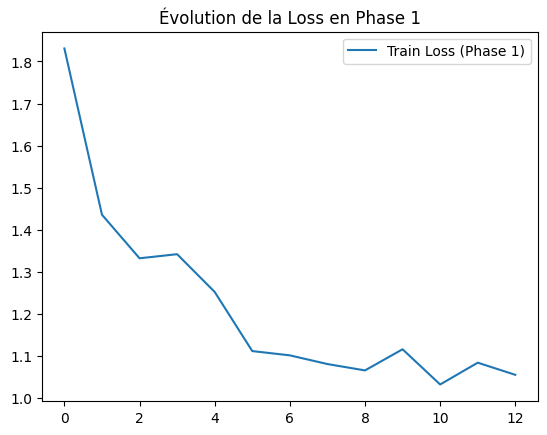

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from tqdm import tqdm

# ------------------------------------
# 1) Geler une partie du modèle
# ------------------------------------
# Supposons que vous ayez un modèle 'model' déjà chargé + MixUp / CutMix configuré.
# Par exemple, geler les 2/3 des couches:
num_layers_to_freeze = int(len(list(model.parameters())) * 2/3)
frozen_count = 0
for param in model.parameters():
    frozen_count += 1
    if frozen_count <= num_layers_to_freeze:
        param.requires_grad = False
    else:
        param.requires_grad = True

# ------------------------------------
# 2) Label smoothing
# ------------------------------------
# CrossEntropy avec label_smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ------------------------------------
# 3) Optimiseur + Scheduler Cosine
# ------------------------------------
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# ------------------------------------
# 4) Boucle d'entraînement "Phase 1"
# ------------------------------------
EPOCHS = 20
best_val_loss = float('inf')
best_weights = None
patience = 5
patience_counter = 0

train_losses = []
val_losses   = []
val_accs     = []

for epoch in range(EPOCHS):
    print(f"\n[Phase 1] Epoch [{epoch+1}/{EPOCHS}]")

    # === Phase d'entraînement ===
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # MixUp / CutMix
        mixed_images, mixed_labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = criterion(outputs, mixed_labels)  # label_smoothing + MixUp => OK
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Phase de validation ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Pour la validation, on ne fait pas de MixUp, on calcule la CE standard
            loss_ce = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss_ce.item()

            # Accuracy
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / total
    val_losses.append(val_loss)
    val_accs.append(accuracy)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

    # Scheduler (Cosine)
    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered (Phase 1).")
            break

# Charger les meilleurs poids de la phase 1
model.load_state_dict(best_weights)
print(">>> Meilleur modèle (Phase 1) chargé.")

# ----------------------------------------------------
# 5) Défreeze TOUT le modèle => Phase 2 (fine-tuning)
# ----------------------------------------------------
for param in model.parameters():
    param.requires_grad = True

# On définit un nouvel optim + scheduler (LR plus bas)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

EPOCHS2 = 30
best_val_loss2 = float('inf')
best_weights2 = None
patience_counter2 = 0

for epoch in range(EPOCHS2):
    print(f"\n[Phase 2] Epoch [{epoch+1}/{EPOCHS2}]")

    # === Train ===
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # MixUp / CutMix
        mixed_images, mixed_labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = criterion(outputs, mixed_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # === Val ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_ce = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss_ce.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / total

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

    scheduler2.step()

    # Early stopping
    if val_loss < best_val_loss2:
        best_val_loss2 = val_loss
        best_weights2 = copy.deepcopy(model.state_dict())
        patience_counter2 = 0
    else:
        patience_counter2 += 1
        if patience_counter2 >= patience:
            print("Early stopping triggered (Phase 2).")
            break

model.load_state_dict(best_weights2)
print(">>> Meilleur modèle (Phase 2) chargé.")

# ----------------------------------------
# 6) Sauvegarde du modèle final sur disque
# ----------------------------------------
torch.save(model.state_dict(), "model_finetuned_mixup.pth")
print(">>> Fichier model_finetuned_mixup.pth sauvegardé")

# ----------------------------------------
# 7) Visualisation des courbes (optionnel)
# ----------------------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Train Loss (Phase 1)")
# NB : vous pouvez fusionner ou distinguer Phase 2, etc.
plt.title("Évolution de la Loss en Phase 1")
plt.legend()
plt.show()


In [13]:
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import timm  # si vous utilisez ConvNeXt ou un autre modèle timm

# --------------------------------------------------
# 📦 Dataset pour test (pas de labels dans les noms)
# --------------------------------------------------
class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None, img_size=(300,300)):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)

        # Ouverture, conversion en RGB, resize
        image = Image.open(img_path).convert("RGB").resize(self.img_size)
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]
        return image, filename

# --------------------------------------------------
# 🔧 Préparation
# --------------------------------------------------
image_dir = "/content/drive/MyDrive/datatest"
# Chemin vers votre dossier contenant les images de test

test_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
print(f"Nombre d'images trouvées: {len(test_files)}")

# Exemple de transformations (à ajuster selon votre entraînement)
val_transform = A.Compose([
    A.Resize(300, 300),  # même taille que lors de l'entraînement
    A.Normalize(),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --------------------------------------------------
# 🔍 Chargement du modèle entraîné
# --------------------------------------------------
NUM_CLASSES = 9

# Remplacez 'convnext_base' par l'architecture exacte
# utilisée lors de l'entraînement si nécessaire
model = timm.create_model(
    'convnext_base',  # ou convnext_tiny, convnext_small, etc.
    pretrained=False, # on charge nos poids persos, donc pas les poids ImageNet
    num_classes=NUM_CLASSES
)

# Charger les poids depuis votre fichier
# (ici on suppose que vous avez sauvegardé sous "model_finetuned_mixup.pth")
state_dict = torch.load("model_finetuned_mixup.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()
print("✅ Modèle chargé et prêt pour l'inférence")

# --------------------------------------------------
# 📤 Dataset et DataLoader
# --------------------------------------------------
test_dataset = ImageDatasetWithoutLabels(
    image_dir=image_dir,
    image_filenames=test_files,
    transform=val_transform,
    img_size=(300, 300)  # Ajustez si votre modèle attend 224x224 ou autre
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✅ Test loader prêt")

# --------------------------------------------------
# 🧠 Inférence + création de la soumission
# --------------------------------------------------
submission_rows = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Prédictions: argmax des logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            # On enlève l'extension .jpg pour faire un ID plus propre
            img_id = os.path.splitext(filename)[0]
            submission_rows.append((img_id, pred))

# --------------------------------------------------
# 💾 Export CSV
# --------------------------------------------------
submission_df = pd.DataFrame(submission_rows, columns=["idx", "gt"])
submission_df.to_csv("submission_convnext1.csv", index=False)
print("✅ Fichier de prédiction généré : submission_convnext.csv")


Nombre d'images trouvées: 1344
✅ Device: cuda
✅ Modèle chargé et prêt pour l'inférence
✅ Test loader prêt


100%|██████████| 42/42 [01:20<00:00,  1.92s/it]

✅ Fichier de prédiction généré : submission_convnext.csv
